# P300 Speller Classification Via Different ML Models
Created By: Aurelio Barrios

***Disclaimer: Some of the implementations found in this jupyter notebook are derived from Assignment 2 of Cogs 189. There are minor alterations to the way I read in my data due to it being in a different format.***

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Imports

In [2]:
import numpy as np                                      
import matplotlib.pyplot as plt                         
import matplotlib.patches as patches
import scipy.signal as signal
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

### Designing A Filter

In [3]:
# Define our filter variables
fs = 240.0                      # Hz; sampling rate
dt = 1000/fs                    # ms; time between samples
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 30.                        # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

### Window of Focus

In [4]:
# Define ERP-related variables
epoch_start = 0    # ms
epoch_end = 700    # ms
baseline_start = 0 # ms
baseline_end = 100 # ms
erp_start = 200    # ms
erp_end = 550      # ms

# Let's translate these into index space to save time later
e_s = np.round(epoch_start / sdt).astype(int)     # epoch start
e_e = np.round(epoch_end / sdt).astype(int)       # epoch end
bl_s = np.round(baseline_start / sdt).astype(int) # baseline start
bl_e = np.round(baseline_end / sdt).astype(int)   # baseline end
erp_s = np.round(erp_start / sdt).astype(int)     # ERP start
erp_e = np.round(erp_end / sdt).astype(int)       # ERP end

# We'll also create our channel labels here since the document only provided a figure
channels = np.array(['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6',
                     'C5',  'C3',  'C1',  'Cz',  'C2',  'C4',  'C6',
                     'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
                     'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8',
                     'F7',  'F5',  'F3',  'F1',  'Fz',  'F2',  'F4',  'F6', 'F8',
                     'FT7', 'FT8', 'T7',  'T8',  'T9',  'T10', 'TP7', 'TP8', 
                     'P7',  'P5',  'P3',  'P1',  'Pz',  'P2',  'P4',  'P6', 'P8',
                     'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1',  'Oz',  'O2', 'Iz'])

### Data Processing

In [5]:
import os

prfx = 'Subject_A'
directory = './data/'

train_data = []
train_labels = []
train_markers = []
test_data = []
test_markers = []

for p in ['Subject_A']:
    for filename in os.listdir(directory):
        fp = directory + filename
        if p in fp:
            fp = Path(fp)
            if fp.exists() and fp.is_file():
                print('Processing: ' + str(fp))
                #process the data
                x = loadmat(fp)

                #get the EEG data and markers
                data_ = x['Signal'][0]
                mrks_ = x['StimulusCode'][0]
                for i in range(1, x['Signal'].shape[0]):
                    data_ = np.concatenate((data_, x['Signal'][i]))
                    mrks_ = np.concatenate((mrks_, x['StimulusCode'][i]))              
                #create stimulus onset array
                onsets = np.zeros_like(mrks_)
                for i in range(mrks_.shape[0]):
                    if mrks_[i] != 0 and mrks_[i-1] == 0:
                        onsets[i] = 1

                #determine where onsets occur
                onsets_ix = np.where(onsets == 1)[0]

                for i in range(len(onsets_ix)):
                    t0 = onsets_ix[i]

                    data = data_[e_s+t0:t0+e_e, :] - np.mean(data_[e_s+t0:t0+e_e, :], 0)
                    data = sosfiltfilt(sos, data)

                    # Now let's baseline correct
                    data = data - np.mean(data[bl_s+np.abs(e_s):np.abs(e_s)+bl_e, :], 0)

                    # Append data to correct locations
                    if 'Train' in str(fp):
                        train_data.append(data)
                        train_markers.append(mrks_[t0])
                        train_labels.append(x['StimulusType'].flatten()[t0]) # target or non-target
                    else:
                        test_data.append(data)
                        test_markers.append(mrks_[t0])              
                    
print('Processing completed!')

# Convert all of our lists into numpy arrays
train_data = np.array(train_data)
#added
# train_data = train_data[0]
train_labels = np.array(train_labels)
train_markers = np.array(train_markers)
test_data = np.array(test_data)
#added
# test_data = test_data[0]
test_markers = np.array(test_markers)

Processing: data/Subject_A_Train.mat
Processing: data/Subject_A_Test.mat
Processing completed!


### Signal Extraction

We have 2550 target trials
We have 12750 non-target trials


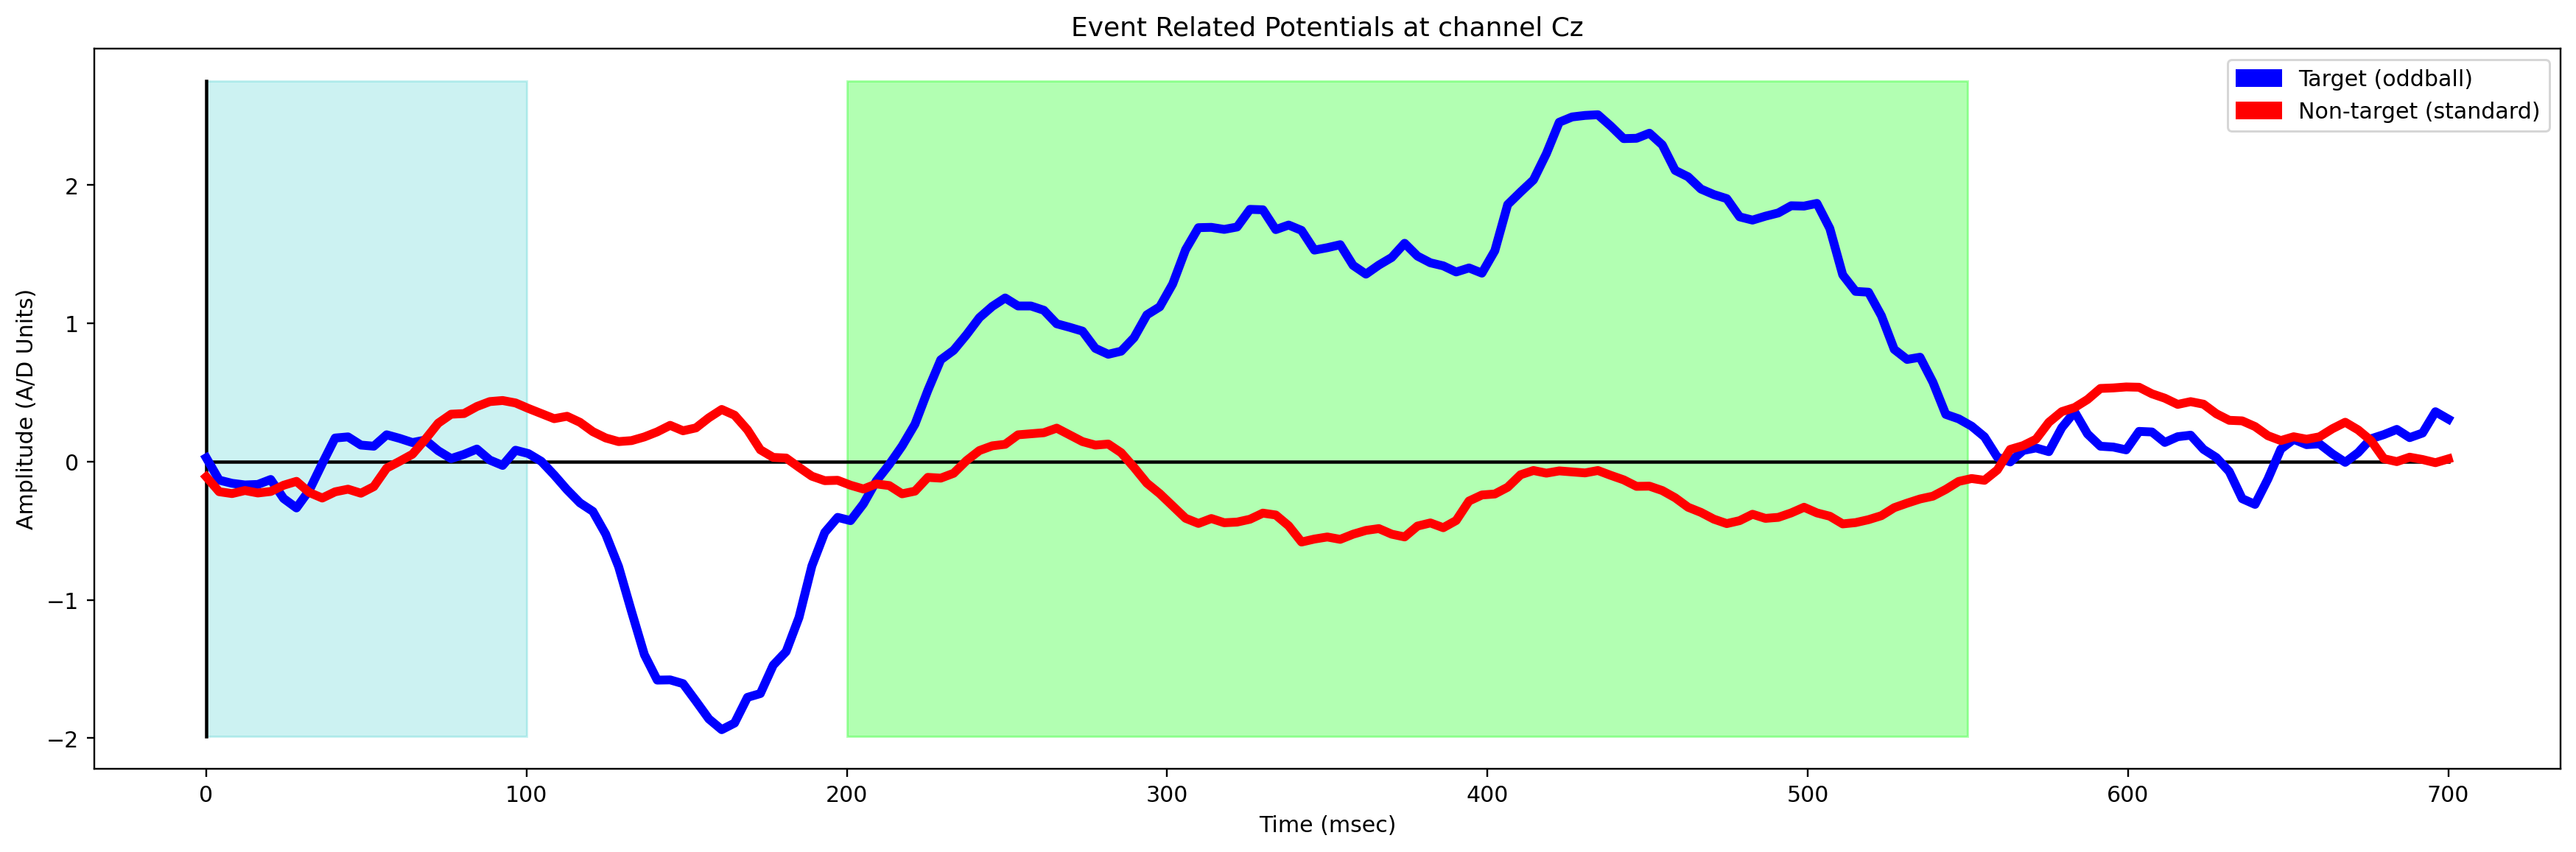

In [6]:
# Seperate target and non-target for plotting
tar     = train_data[np.where(train_labels == 1)[0], :, :]
non_tar = train_data[np.where(train_labels == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = 'Cz' # let's plot Cz
ch = np.where(channels == chan)[0][0]
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.savefig('image1.png')
plt.show();

### Data Processing for Machine Learning Models

In [7]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(train_data, erp_s, erp_e, num_points)
markers_train = np.vstack((train_labels, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

X_train shape is: (5, 64, 15300)
y shape is......: (15300,)
X_test shape is.: (5, 64, 18000)


In [8]:
X_train = X_train[:-1]
X_test = X_test[:-1]

In [9]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

X_train shape is now: (15300, 256)
X_test  shape is now: (18000, 256)


### LDA Baseline Model

In [10]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

In [11]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))

solver = lsqr  accuracy: 0.829869


## SVM

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [13]:
score_svc = cross_val_score(clf_svc.fit(X_train, y), X_train, y, cv = 5)

print("solver = svc  accuracy: %f" % np.mean(score_svc))

solver = svc  accuracy: 0.833333


## LinearSVC Model

In [14]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_lsvc = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=0, tol=1e-5))

In [15]:
score_lsvc = cross_val_score(clf_lsvc.fit(X_train, y), X_train, y, cv = 5)

print("solver = lsvc  accuracy: %f" % np.mean(score_lsvc))

solver = lsvc  accuracy: 0.830915


## Logistic Regression Model

In [16]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state=0)

In [17]:
score_lr = cross_val_score(clf_lr.fit(X_train, y), X_train, y, cv = 5)

print("solver = lr  accuracy: %f" % np.mean(score_lr))

solver = lr  accuracy: 0.830784


## Decision Tree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()

In [19]:
score_tree = cross_val_score(clf_tree.fit(X_train, y), X_train, y, cv = 5)

print("solver = tree  accuracy: %f" % np.mean(score_tree))

solver = tree  accuracy: 0.714575


## Multilayer Perceptron

In [25]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2),
                       random_state=0).fit(X_train, y)

In [21]:
score_mlp = cross_val_score(clf_mlp.fit(X_train, y), X_train, y, cv = 5)

print("solver = mlp  accuracy: %f" % np.mean(score_mlp))

solver = mlp  accuracy: 0.832092


## End of Testing Models

In [34]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
nfolds = 5;
cv = StratifiedKFold(n_splits = nfolds)
X = X_train
tprs_lsqrs = [];
aucs_lsqrs = [];
mean_fpr_lsqrs = np.linspace(0, 1, 100);

i = 0
for train, test in cv.split(X, y):
    probas_lsqrs = clf_lsqrs.fit(X[train], y[train]).predict_proba(X[test])
    fpr_lsqrs, tpr_lsqrs, th_lsqrs = roc_curve(y[test], probas_lsqrs[:, 1])
    tprs_lsqrs.append(np.interp(mean_fpr_lsqrs, fpr_lsqrs, tpr_lsqrs))
    tprs_lsqrs[-1][0] = 0.0
    roc_auc_lsqrs = auc(fpr_lsqrs, tpr_lsqrs)
    aucs_lsqrs.append(roc_auc_lsqrs)
    i += 1

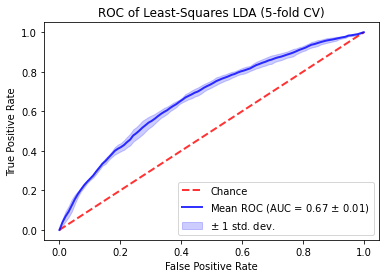

In [35]:
# Modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr_lsqrs = np.mean(tprs_lsqrs, axis=0)
mean_tpr_lsqrs[-1] = 1.0
mean_auc_lsqrs = auc(mean_fpr_lsqrs, mean_tpr_lsqrs)
std_auc_lsqrs = np.std(aucs_lsqrs);

plt.plot(mean_fpr_lsqrs, mean_tpr_lsqrs, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lsqrs, std_auc_lsqrs),
         lw=2, alpha=.8)

std_tpr_lsqrs = np.std(tprs_lsqrs, axis=0)
tprs_upper_lsqrs = np.minimum(mean_tpr_lsqrs + std_tpr_lsqrs, 1)
tprs_lower_lsqrs = np.maximum(mean_tpr_lsqrs - std_tpr_lsqrs, 0)
plt.fill_between(mean_fpr_lsqrs, tprs_lower_lsqrs, tprs_upper_lsqrs, color='b', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Least-Squares LDA (' + str(nfolds) + '-fold CV)')
plt.legend(loc="lower right")
plt.show()

In [93]:
# Set clf to clf_lsqrs for convenience
clf = clf_lsqrs.fit(X_train, y)

# Make predictions on our dataset 

conf = clf.decision_function(X_test) # predicted confidence score

pred = clf.predict(X_test)           # predicted label (we won't actually use this)

In [94]:
# Here are the translations for the labels:
# Columns 0-5 -> Labels 1-6
# Rows 0-5 -> Labels 7-12
# Let's create this matrix
#                         1    2    3    4    5    6
char_matrix = np.array([['A', 'B', 'C', 'D', 'E', 'F'], # 7
                        ['G', 'H', 'I', 'J', 'K', 'L'], # 8
                        ['M', 'N', 'O', 'P', 'Q', 'R'], # 9
                        ['S', 'T', 'U', 'V', 'W', 'X'], # 10
                        ['Y', 'Z', '1', '2', '3', '4'], # 11
                        ['5', '6', '7', '8', '9', '0']])# 12 

In [95]:
# Define some useful variables
char_breaks = 15 * 12 # number of stimuli per character
c = 1;                # which character we want

# Grab our first character's marker, prediction, and confidence
char1_mrks = markers_test[char_breaks*(c-1):char_breaks*c]
char1_pred = pred[char_breaks*(c-1):char_breaks*c]
char1_conf = conf[char_breaks*(c-1):char_breaks*c]

# Let's merge these
char1 = np.array([char1_mrks, char1_pred, char1_conf]).T

In [96]:
# Alright, now let's sort them by the 3rd column, the confidence
# Nice 1-liner provided by https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
char1_sort = char1[char1[:,2].argsort()[::-1]]

# Let's print out the first 5 results
print(char1_sort[0:5, :])

[[ 3.          0.         -0.4833791 ]
 [ 1.          0.         -0.72514062]
 [ 5.          0.         -0.76924152]
 [ 6.          0.         -0.81931677]
 [ 5.          0.         -0.93497421]]


In [97]:
# Now we will store the average confidence value for every row/column
x = np.zeros(shape = (12, 1))
for i in range(0, x.shape[0]):
    x[i] = np.mean(char1_sort[char1_sort[:, 0] == i + 1, 2])
    
# Now let's print our character
row = np.argmax(x[6:])
col = np.argmax(x[0:6])
our_char = char_matrix[row, col]
print('Our character is: %s' % our_char)

Our character is: W


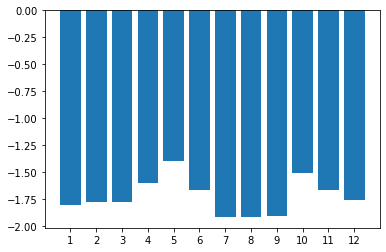

In [98]:
# Let's quickly visualize the average confidence scores with a bar plot
plt.figure()
ticks = np.array(range(1, x.shape[0] + 1, 1))
plt.bar(ticks, np.ravel(x), tick_label = ticks)
plt.show()

## Test Set Results

In [99]:
# Main loop: Iterate through test data by chunking every 15x12 trials per character
#  Nest 1: Calculate mean of character
char_breaks = 15*12
output_string = ''
for c in range(1, int(X_test.shape[0] / char_breaks) + 1):
    # Lets break up test into char 'c'
    temp_mrks = markers_test[char_breaks * (c - 1):char_breaks * c]
    temp_pred = pred[char_breaks * (c - 1):char_breaks * c]
    temp_conf = conf[char_breaks * (c - 1):char_breaks * c]

    # Let's merge these and sort by highest confidence
    temp_char = np.array([temp_mrks, temp_pred, temp_conf]).T
    temp_char = temp_char[temp_char[:, 2].argsort()[::-1]]
    
    # Create our averages
    x = np.zeros(shape = (12, 1))
    for i in range(0, x.shape[0]):
        x[i, 0] = np.mean(temp_char[temp_char[:, 0] == i + 1, 2])
        
    # Now let's print our character
    row = np.argmax(x[6:,  0])
    col = np.argmax(x[0:6, 0])
    our_char = char_matrix[row, col]
    output_string += our_char + ' '
    
# Print our result
print(output_string)

W Q X P L Z O O M R K O L 8 Y B Z D E Z 1 D P 0 9 N Q V G R Q F L T U L R M E U C 7 O J D Q U F Y P O O 8 7 7 L D G Y R G O A 5 V Z N W K B U 4 O O 1 T D O I L U E D A 7 A G E E X A E 0 K 1 R 9 M R U 


In [100]:
real = 'W Q X P L Z C O M R K O 9 7 Y F Z D E Z 1 D P I 9 N N V G R Q D J C U V R M E U O O O J D 2 U F Y P O O 6 J 7 L D G Y E G O A 5 V H N E H B T X O O 1 T D O I L U E E 5 B F A E E X A W _ K 4 R 3 M R U' 

In [101]:
print(real)

W Q X P L Z C O M R K O 9 7 Y F Z D E Z 1 D P I 9 N N V G R Q D J C U V R M E U O O O J D 2 U F Y P O O 6 J 7 L D G Y E G O A 5 V H N E H B T X O O 1 T D O I L U E E 5 B F A E E X A W _ K 4 R 3 M R U


In [102]:
output_l = output_string.split()
real_l = real.split()

In [103]:
index = 0
correct = 0
while index < len(output_l):
    
    if real_l[index] == output_l[index]:
        correct += 1
    
    index += 1

In [106]:
print('Test output correct accuracy: ' + str(correct / len(output_l)))

Test output correct accuracy: 0.7
